## Technical analysis - Fibonacci retracement

We will cover functions to draw dynamic Fibonacci retracement and general ones, and draw candlestick plot at the end. This is a preparation for study trading strategy based on Fibonacci retracement.

In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (26,10)

# client configuration
api_key = 'API HERE'
api_secret = 'SECRET API HERE'
client = Client(api_key, api_secret)

# function to fetch_data, source: Binance
def fetch_data(symbol, interval, start): 
    # format of start date: "1 Mar, 2021"
    symbol = symbol
    interval= interval
    start = start
    Client.KLINE_INTERVAL_1DAY
    klines = client.get_historical_klines(symbol, interval, start)
    data = pd.DataFrame(klines)
     # create colums name
    data.columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
    data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.close_time]
    #data.to_csv(symbol+'.csv', index = None, header=True)
    df=data.loc[:, ['open', 'high', 'low', 'close', 'volume', 'qav','num_trades','taker_base_vol','taker_quote_vol']].astype(float)
    #df["close"].plot(title = str(symbol), legend = 'close')
    dates = df.index[1:]
    close = df['close']
    high = df['high']
    low = df['low']
    return df

Data for this test is daily price BTCUSD, i.e.interval 1d, with time frame: March 1, 2021 to the date of running this script.

In [2]:
symbol = 'BTCUSDT'
interval = "1d"
start = "28 February, 2021"
data = fetch_data(symbol, interval, start) 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 381 entries, 2021-03-01 07:59:59.999000 to 2022-03-16 07:59:59.999000
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             381 non-null    float64
 1   high             381 non-null    float64
 2   low              381 non-null    float64
 3   close            381 non-null    float64
 4   volume           381 non-null    float64
 5   qav              381 non-null    float64
 6   num_trades       381 non-null    float64
 7   taker_base_vol   381 non-null    float64
 8   taker_quote_vol  381 non-null    float64
dtypes: float64(9)
memory usage: 29.8 KB


Let's plot daily close price.

<AxesSubplot:title={'center':'BTCUSDT'}>

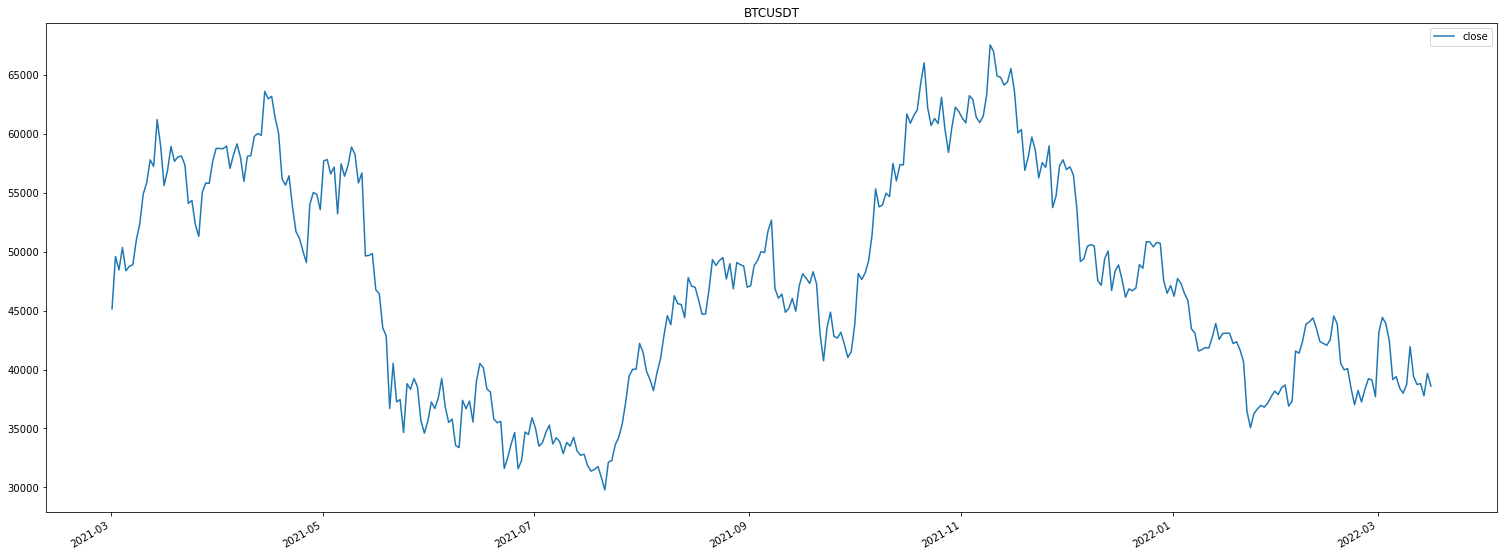

In [3]:
df = data.loc[:,:]
df["close"].plot(title = str(symbol), legend = 'daily close')

### Dynamic Fibonacci retracement 

In this session, we build a function to generate multiple sets of Fibonacci retracement which only capture the significant upward or downward trends. Significant trends is defined as the price ranges, i.e. differences between "local highs" and "local lows" are above 75% percentile of the whole dataset. Then we apply the function ..... to draw sets of Fibonacci retracement levels of significant trends.

In [4]:
# We calculate difference between local high and local low within rolling 7 days through the period.
# col max: local high
# col min: local low
# col diff_l: max - min

def max_diff(df):
    max_l = df.high.rolling(window=7).apply(lambda x:max(x)).rename('max')
    min_l = df.low.rolling(window=7).apply(lambda x:min(x)).rename('min')
    dif_df = pd.concat([max_l,min_l],axis=1)
    dif_df["diff_l"] = dif_df['max'] - dif_df['min']
    return dif_df
dif_l = max_diff(df).dropna()
dif_l 

,max,min,diff_l
2021-03-07 07:59:59.999,52640.00,43000.00,9640.00
2021-03-08 07:59:59.999,52640.00,44950.53,7689.47
2021-03-09 07:59:59.999,52640.00,46300.00,6340.00
2021-03-10 07:59:59.999,54895.00,46300.00,8595.00
2021-03-11 07:59:59.999,57387.69,46300.00,11087.69
...,...,...,...
2022-03-12 07:59:59.999,42594.06,37155.00,5439.06
2022-03-13 07:59:59.999,42594.06,37155.00,5439.06
2022-03-14 07:59:59.999,42594.06,37155.00,5439.06
2022-03-15 07:59:59.999,42594.06,37555.00,5039.06


In [5]:
dif_l.diff_l.describe()

count      375.000000
mean      7571.237467
std       3239.408361
min       2932.560000
25%       5321.000000
50%       6729.640000
75%       9209.000000
max      21483.000000
Name: diff_l, dtype: float64

We find 75% percentile of ranges is 9209. We label 1 for the range larger than 9209. We also want to filter out those increasingly upward trends, captured by positive first order of difference between high and low, aka range.

In [6]:
dif_l['sig_dif'] = [[0, 1][x >= 9298.1675] for x in dif_l.diff_l]
df_sig_dif = dif_l[dif_l['sig_dif']==1] #label 1 for the range larger than 9209.

In [7]:
# increasing ranges which are higher then 75th percentile, and their corresponding end date point.  
df_sig_diff_increasing = df_sig_dif[df_sig_dif.diff_l.diff()>0]
df_sig_diff_increasing 

,max,min,diff_l,sig_dif
2021-03-11 07:59:59.999,57387.69,46300.00,11087.69,1
2021-03-12 07:59:59.999,58150.00,46300.00,11850.00,1
2021-03-14 07:59:59.999,61844.00,48882.20,12961.80,1
2021-04-19 07:59:59.999,64854.00,50931.30,13922.70,1
2021-04-23 07:59:59.999,63520.61,50500.00,13020.61,1
2021-04-24 07:59:59.999,62506.05,47500.00,15006.05,1
2021-05-01 07:59:59.999,57963.00,46930.00,11033.00,1
2021-05-02 07:59:59.999,58458.07,46930.00,11528.07,1
2021-05-13 07:59:59.999,59500.00,48600.00,10900.00,1
2021-05-14 07:59:59.999,59500.00,46000.00,13500.00,1


Function "fib_levels" calculates Fibonacci retracement levels given local highs and local lows.

In [8]:
def fib_levels(df_sig_dif):
    levels=[]
    levels_df = pd.DataFrame()
    ratios = [0,0.236, 0.382, 0.5 , 0.618, 0.786,1]
    for ratio in ratios:
        levels.append(df_sig_dif['max'] - df_sig_dif['diff_l']*ratio)
        levels_df = pd.DataFrame(levels).T
    return levels_df

Here we only care about Fibonacci retracement levels within increasing upward or downward trends.
The output dataframe columns labeled as 0-6 containing each Fibonacci retracement levels, rows labeled the end time points of each significant trends.


In [9]:
fib_levels(df_sig_diff_increasing) 

,0,1,2,3,4,5,6
2021-03-11 07:59:59.999,57387.69,54770.99516,53152.19242,51843.845,50535.49758,48672.76566,46300.00
2021-03-12 07:59:59.999,58150.00,55353.40000,53623.30000,52225.000,50826.70000,48835.90000,46300.00
2021-03-14 07:59:59.999,61844.00,58785.01520,56892.59240,55363.100,53833.60760,51656.02520,48882.20
2021-04-19 07:59:59.999,64854.00,61568.24280,59535.52860,57892.650,56249.77140,53910.75780,50931.30
2021-04-23 07:59:59.999,63520.61,60447.74604,58546.73698,57010.305,55473.87302,53286.41054,50500.00
2021-04-24 07:59:59.999,62506.05,58964.62220,56773.73890,55003.025,53232.31110,50711.29470,47500.00
2021-05-01 07:59:59.999,57963.00,55359.21200,53748.39400,52446.500,51144.60600,49291.06200,46930.00
2021-05-02 07:59:59.999,58458.07,55737.44548,54054.34726,52694.035,51333.72274,49397.00698,46930.00
2021-05-13 07:59:59.999,59500.00,56927.60000,55336.20000,54050.000,52763.80000,50932.60000,48600.00
2021-05-14 07:59:59.999,59500.00,56314.00000,54343.00000,52750.000,51157.00000,48889.00000,46000.00


Visualizing by drawing sets of Fibonacci retracement levels under "significant" rules defined earlier.

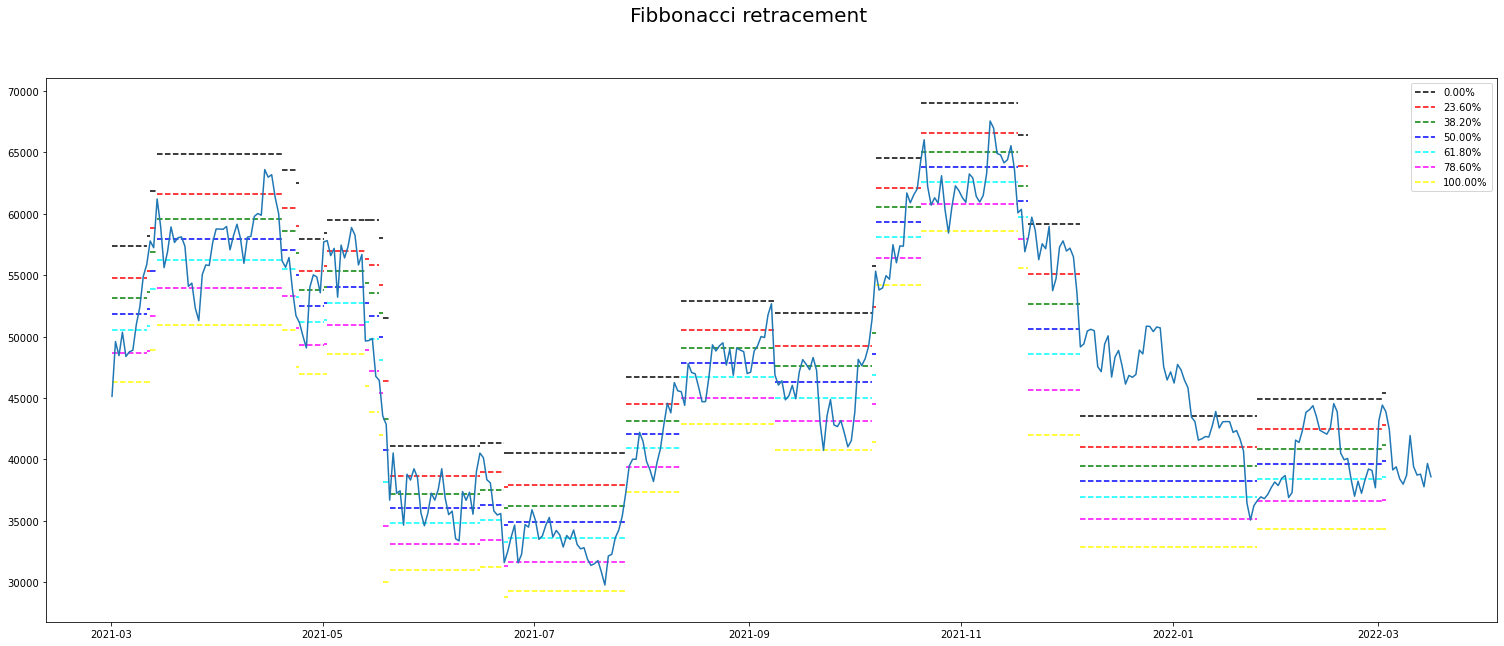

In [10]:
plot_df = fib_levels(df_sig_diff_increasing)
#plt.rcParams["figure.figsize"] = (26,10)
fig = plt.figure(figsize=(26,10))
fig.suptitle("Fibbonacci retracement", fontsize=20)

ax = fig.add_subplot()
ax.plot(df['close'])
colors = ["black","r","g","b","cyan","magenta","yellow"]
ratios = [0,0.236, 0.382, 0.5 , 0.618, 0.786,1]
# First set
for j in range(7):
    ax.hlines(plot_df.iloc[0,j],df.index[0],plot_df.index[0],label = "{:.2f}%".format(ratios[j] * 100),
              linestyles="dashed",colors=colors[j])
    ax.legend()
# From second onwards
for i in range(1, plot_df.shape[0]):
    for j in range(7):
        ax.hlines(plot_df.iloc[i,j],plot_df.index[i-1] , plot_df.index[i],label = "{:.2f}%".format(ratios[j] * 100),
                  linestyles="dashed",colors=colors[j])

### Function to generate general Fibonacci retracement levels

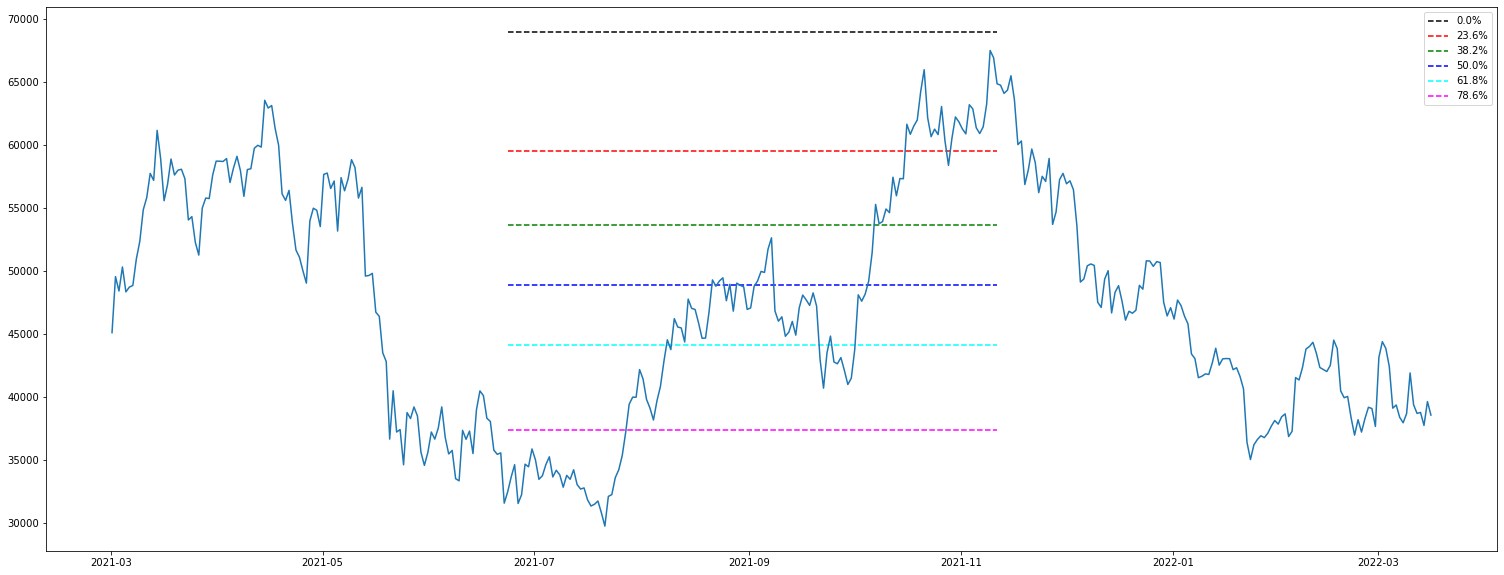

In [11]:
def levels(df):
    highest_swing = -1
    lowest_swing = -1
    for i in range(1,df.shape[0]-1):
        if df['high'][i] > df['high'][i-1] and df['high'][i] > df['high'][i+1] and (highest_swing == -1 or df['high'][i] > df['high'][highest_swing]):
            highest_swing = i
        if df['low'][i] < df['low'][i-1] and df['low'][i] < df['low'][i+1] and (lowest_swing == -1 or df['low'][i] < df['low'][lowest_swing]):
            lowest_swing = i
    ratios = [0,0.236, 0.382, 0.5 , 0.618, 0.786,1]
    colors = ["black","r","g","b","cyan","magenta","yellow"]
    levels =[]
    max_level = df['high'][highest_swing]
    min_level = df['low'][lowest_swing]
    
    for ratio in ratios:
        if highest_swing > lowest_swing:# Uptrend
            #levels.contact(df.index())
            levels.append(max_level - (max_level-min_level)*ratio)
            
        else: # Downtrend
            levels.append(min_level + (max_level-min_level)*ratio)

    start_date = df.index[min(highest_swing,lowest_swing)]
    end_date = df.index[max(highest_swing,lowest_swing)]
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(df['close'])
    for i in range(len(levels)-1):
        ax.hlines(levels[i],start_date, end_date,label="{:.1f}%".format(ratios[i]*100),
                  colors=colors[i], linestyles="dashed")
    ax.legend()

levels_list = []
levels(data)

### Plot candlestick

Candlestick price is more applicable to study trading strategy than line graph. We plot candlestick graph below. However, this test does not conclude draw up Fibonacci retracement levels on candlestick, which needs further explore.

In [12]:
import plotly.offline as py
import plotly.graph_objs as go

def plotCandlestick():
    py.init_notebook_mode(connected=True)
    data_cand = [go.Candlestick(x=df.index,
                           open=df.open,
                           high=df.high,
                           low=df.low,
                           close=df.close)]

    layout = go.Layout(title='Bitcoin Candlestick with Range Slider',
                       #'pattern':'size':1,
                       xaxis={'rangeselector':{'buttons':[{'count':7,
                                                          'label':'1w',
                                                          'step':'day',
                                                          'stepmode':'backward'},
                                                         {'count':1,
                                                          'label':'1m',
                                                          'step':'month',
                                                          'stepmode':'backward'},
                                                        {'count':3,
                                                          'label':'3m',
                                                          'step':'month',
                                                          'stepmode':'backward'},
                                                        {'count':6,
                                                          'label':'6m',
                                                          'step':'month',
                                                          'stepmode':'backward'},
                                                        {'count':1,
                                                          'label':'1y',
                                                          'step':'year',
                                                          'stepmode':'backward'},
                                                          ]},
                              'rangeslider':{'visible':True}})

    fig = go.Figure(data=data_cand,layout=layout)
    py.iplot(fig,filename='bitcoin_candlestick')

In [13]:
plotCandlestick()